Logistic Regression for CBOW
-----------------------------------------------

This is a basic and not-scalable implementation of CBOW without considering scalability issue. A more scalable implementation can be found at <a href="https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py">word2vec basic implementation on Tensorflow</a>

In [185]:
import tensorflow as tf
import numpy as np
from nltk import word_tokenize
from random import shuffle
import os

In [186]:
train_ngrams = ['study in the united states',
'live in new zealand',
'study in canada UNK canadian',
'study in the january NUM',
'stay in the new england',
'study in the december NUM',
'study in the us PUN',
'live in the us END_S',
'study in the united kingdom'
'live in the usa PUN'
'study in clinical trials PUN',
'work in the united states',
'work in australia PUN',
'its meeting on NUM january',
'annual meeting on NUM december',
'a meeting on january NUM',
'ordinary meeting on NUM december',
'regular meeting of february NUM']

dev_ngrams = ['study in China',
'study in new zealand',
'live in canada',
'work in the january NUM',
'live in the new england',
'a meeting in the december NUM',
'live in the us PUN',
'work in the us END_S',
'stay in the united kingdom'
'work in the usa PUN',
'stay in australia PUN',
'work in australia PUN',
'its meeting on NUM december',
'a meeting on january NUM',
'ordinary meeting on NUM november']

In [187]:
import collections
from collections import namedtuple
Ngram = namedtuple('Ngram', 'context c_word')

In [188]:
def tokenize(ngram):
    return word_tokenize(ngram)

## Build vocabulary

In [189]:
def build_vocab(train_set):
    words = list()
    for ngram in train_set:
        tokens = tokenize(ngram)
        words.extend(tokens)
    count = collections.Counter(words).most_common()
    word_to_id = dict()
    word_to_id['PAD'] = 0
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))
    return word_to_id, id_to_word

Map each word to its ID and build the reverse map.

In [190]:
def map_token_seq_to_word_id_seq(token_seq, word_to_id):
    return [map_word_to_id(word_to_id,word) for word in token_seq]


def map_word_to_id(word_to_id, word):
    if word in word_to_id:
        return word_to_id[word]
    else:
        return word_to_id['PAD']


Build a training dataset. Each instance(data point) consists of the ID of a word and the IDs of its context words.

In [191]:
def build_dataset(train_set, word_to_id, window_size):
    dataset = list()
    for ngram in train_set:
        tokens = tokenize(ngram)
        word_id_seq = map_token_seq_to_word_id_seq(tokens, word_to_id)
        for i in range(len(word_id_seq)):
            word_context = [word_to_id['PAD']] * 2 * window_size
            for p_in_context in range(window_size):
                # position to the left of the current word in the given ngram
                p_left_ngram = i - window_size + p_in_context
                if p_left_ngram >= 0:
                    word_context[p_in_context] = word_id_seq[p_left_ngram]
                # position to the right of the current word in the given ngram
                p_right_ngram = i + p_in_context + 1
                if p_right_ngram < len(word_id_seq):
                    word_context[p_in_context + window_size] = word_id_seq[p_right_ngram]
            # word_context is the list of context word ids. c_word is the id of the current word.
            ngram_inst = Ngram(context=word_context, c_word=word_id_seq[i])
            dataset.append(ngram_inst)
    return dataset

In [192]:
def print_dataset(dataset, id_to_word):
    for inst in dataset:
        print("%s : %s" % ([id_to_word[id] for id in inst.context], id_to_word[inst.c_word]))

In [115]:
word_to_id, id_to_word = build_vocab(train_ngrams)
train_set = build_dataset(train_ngrams, word_to_id, 2)
dev_set = build_dataset(dev_ngrams, word_to_id, 2)
print_dataset(train_set, id_to_word)

['PAD', 'PAD', 'in', 'the'] : study
['PAD', 'study', 'the', 'united'] : in
['study', 'in', 'united', 'states'] : the
['in', 'the', 'states', 'PAD'] : united
['the', 'united', 'PAD', 'PAD'] : states
['PAD', 'PAD', 'in', 'new'] : live
['PAD', 'live', 'new', 'zealand'] : in
['live', 'in', 'zealand', 'PAD'] : new
['in', 'new', 'PAD', 'PAD'] : zealand
['PAD', 'PAD', 'in', 'canada'] : study
['PAD', 'study', 'canada', 'UNK'] : in
['study', 'in', 'UNK', 'canadian'] : canada
['in', 'canada', 'canadian', 'PAD'] : UNK
['canada', 'UNK', 'PAD', 'PAD'] : canadian
['PAD', 'PAD', 'in', 'the'] : study
['PAD', 'study', 'the', 'january'] : in
['study', 'in', 'january', 'NUM'] : the
['in', 'the', 'NUM', 'PAD'] : january
['the', 'january', 'PAD', 'PAD'] : NUM
['PAD', 'PAD', 'in', 'the'] : stay
['PAD', 'stay', 'the', 'new'] : in
['stay', 'in', 'new', 'england'] : the
['in', 'the', 'england', 'PAD'] : new
['the', 'new', 'PAD', 'PAD'] : england
['PAD', 'PAD', 'in', 'the'] : study
['PAD', 'study', 'the', 'dece

Convert label y = word_id into its vector format with 1-of-K encoding.  

In [116]:
def convert_to_label_vec(word_id, num_words):
    # initialise a zero vector of the length num_words
    label_vec = np.zeros(shape = (num_words, 1))
    label_vec[word_id] = 1
    return label_vec

## CBOW

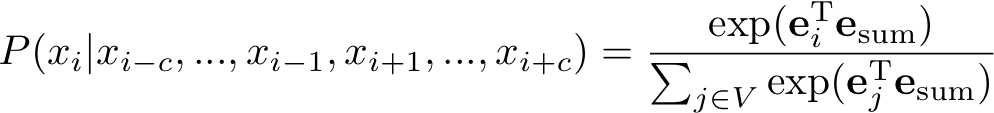

In [166]:
class CBOW(object):
    """
      This is for understanding the key ideas behind CBOW. Unknown words are simply mapped to pad words. 
      Correct procesing of pad words are left as an exercise.
      A more scalable solution is described in https://www.tensorflow.org/tutorials/word2vec.
    """
    def __init__(self, num_words,learning_rate, embedding_dim):
        """Init the model with default parameters/hyperparameters."""
        self.num_words = num_words
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        
    def build_graph(self):
        self.declare_placeholders()
        self.declare_variables()
        self.inference()
        self.optimize()
        self.predict()
        self.compute_accuracy()
        self.performancy_summaries()
        
    def declare_placeholders(self):
        with tf.name_scope('CBOW'):
            self.input_ngram = tf.placeholder(tf.int32, shape = [None], name = 'inputNgram')
            self.correct_label = tf.placeholder(tf.float32, shape=[self.num_words, 1], name = 'trueLabel')
        
    def declare_variables(self):
        with tf.name_scope('CBOW'):
            # Word embeddings are the only parameters of the model
            self.embeddings = tf.Variable(tf.random_uniform([self.num_words, self.embedding_dim], -1.0, 1.0), name='embedding')
    
    def inference(self):
        """Compute the logits of x."""
        # retrieve the row vectors for each context word.
        embed = tf.nn.embedding_lookup(self.embeddings, self.input_ngram)
        tmp_m = tf.reduce_sum(embed, 0)
        sum_rep = tf.reshape(tmp_m, [self.embedding_dim, 1])
        # Formulate word embedding learning as a word prediction task. Note that, no negative sampling is applied here.
        self.logit = tf.matmul(self.embeddings, sum_rep, name = 'logit')
        self.y = tf.nn.softmax(self.logit, axis = 0)
    
    def optimize(self):
        """Train a CBOW model from scratch."""
        self.loss()
        self.train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.cross_entropy)
        
    def compute_accuracy(self):
        """Evaluate the model against a test/validation set"""
        self.accuracy = tf.cast(self.eval_prediction, tf.float32, name = 'accuracy')
        
    def loss_summary(self):
        self.loss_ph = tf.placeholder(tf.float32,shape=None,name='loss_summary')
        # Create a scalar summary object for the loss.
        self.loss_summary = tf.summary.scalar('Loss', self.loss_ph)
    
    def accuracy_summary(self):
        # Feed the mean of validation accuracy to this placeholder.
        self.accuracy_ph = tf.placeholder(tf.float32,shape=None, name='accuracy_summary')
        # Create a scalar summary object for the accuracy.
        self.accuracy_summary = tf.summary.scalar('Accuracy', self.accuracy_ph)

    def performancy_summaries(self):
        # https://www.datacamp.com/community/tutorials/tensorboard-tutorial
        self.loss_summary()
        self.accuracy_summary()
        self.performance_summaries = tf.summary.merge([self.loss_summary,self.accuracy_summary])
        
    def predict(self):
        self.eval_prediction = tf.equal(tf.argmax(self.y, 0), tf.argmax(self.correct_label, 0))
    
    def loss(self):
        """Compute the loss of a batch."""
        # Not scalable
        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.correct_label * tf.log(self.y), reduction_indices=0), name='crossEntropy')
        # Or use tf.nn.softmax_cross_entropy_with_logits_v2
        # Apply NCE https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss for a scalable solution

In [182]:
def train_eval(word_to_id, train_dataset, dev_dataset, num_epochs=10, learning_rate=0.05, embedding_dim=10):
    
    num_words = len(word_to_id)
    model = CBOW(num_words,learning_rate, embedding_dim)
    model.build_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter(os.path.join('summaries','cbow'), sess.graph)
        #print(model.embeddings.eval())
        for epoch in range(num_epochs):
            shuffle(train_dataset)
            loss_per_epoch = []
            for ngram_inst in train_dataset:
                # Run one step of SGD to update word embeddings.
                optimizer, loss = sess.run([model.train_step, model.cross_entropy], feed_dict={model.input_ngram: ngram_inst.context, model.correct_label: convert_to_label_vec(ngram_inst.c_word, model.num_words)})
                loss_per_epoch.append(loss)
            # Print accuracy on train set.
            # For early stopping, you are supposed to run the evaluation on a holdout/validation/development set.
            mean_loss = np.mean(loss_per_epoch)
            mean_accuracy = compute_accuracy(model, dev_dataset)[0]
            print('Epoch %d : loss %s, accuracy on the validation set = %s .' % (epoch, mean_loss, mean_accuracy))
            summ = sess.run(model.performance_summaries, feed_dict={model.loss_ph: mean_loss, model.accuracy_ph: mean_accuracy})
            summary_writer.add_summary(summ, epoch)
        mat = model.embeddings.eval()
        id_to_word = {v: k for k, v in word_to_id.items()}
        for i in range(1, 6):
            print("%s : %s" % (id_to_word[i], mat[i,:]))
        summary_writer.close()

In [183]:
def compute_accuracy(model, eval_dataset):
    num_correct = 0
    for ngram_inst in eval_dataset:
        num_correct += model.accuracy.eval(feed_dict={model.input_ngram: ngram_inst.context, model.correct_label: convert_to_label_vec(ngram_inst.c_word, model.num_words)})
    print('#correct words is %s ' % num_correct)
    return num_correct / len(eval_dataset)

In [184]:
train_eval(word_to_id, train_set, dev_set)

#correct words is [3.] 
Epoch 0 : loss 4.8864555, accuracy on the validation set = 0.04411765 .
#correct words is [6.] 
Epoch 1 : loss 3.192488, accuracy on the validation set = 0.0882353 .
#correct words is [8.] 
Epoch 2 : loss 2.7849176, accuracy on the validation set = 0.11764706 .
#correct words is [7.] 
Epoch 3 : loss 2.595817, accuracy on the validation set = 0.10294118 .
#correct words is [12.] 
Epoch 4 : loss 2.4004643, accuracy on the validation set = 0.1764706 .
#correct words is [12.] 
Epoch 5 : loss 2.292349, accuracy on the validation set = 0.1764706 .
#correct words is [11.] 
Epoch 6 : loss 2.2330701, accuracy on the validation set = 0.16176471 .
#correct words is [11.] 
Epoch 7 : loss 2.1780326, accuracy on the validation set = 0.16176471 .
#correct words is [9.] 
Epoch 8 : loss 2.1063523, accuracy on the validation set = 0.13235295 .
#correct words is [9.] 
Epoch 9 : loss 2.042526, accuracy on the validation set = 0.13235295 .
in : [ 0.54375756 -0.80358404 -0.03696827 -